In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 8)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [4]:
import re
import urllib2
import datetime

import numpy  as np

from collections import Counter, OrderedDict

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, QTable, Column, MaskedColumn
from astropy import table

In [5]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [6]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [7]:
def catalog_to_sc(cat, hostordist = None):
    if hasattr(hostordist, 'dist'):
        distance = hostordist.dist
    else:
        distance = hostordist
        
    return SkyCoord(cat['ra']*u.deg, cat['dec']*u.deg, distance=distance)

# Prepare catalogs

In [20]:
# now set to the latest base catalogs
for h in hsd.values():
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [189]:
nmstoget = ('Dune', 'AnaK', 'Odyssey', 'Gilgamesh', 'OBrother', 'Narnia', 'Catch22')
hosts_to_target = [h for h in hsd.values() if h.name in nmstoget]
assert len(hosts_to_target)==len(nmstoget)

# make sure the catalogs are loaded
for h in hosts_to_target:
    h.get_sdss_catalog()

hosts_to_target

[<hosts.NSAHost object w/ name 'Narnia' AKA: ['NGC1015', 'NSA132339']>,
 <hosts.NSAHost object w/ name 'Catch22' AKA: ['NGC7541', 'NSA150887']>,
 <hosts.NSAHost object w/ name 'Dune' AKA: ['NGC5750', 'NSA165536']>,
 <hosts.NSAHost object w/ name 'OBrother' AKA: ['NSA149781']>,
 <hosts.NSAHost object w/ name 'Gilgamesh' AKA: ['NGC5962', 'NSA166313']>,
 <hosts.NSAHost object w/ name 'AnaK' AKA: ['NGC7716', 'NSA61945']>,
 <hosts.NSAHost object w/ name 'Odyssey' AKA: ['NGC6181', 'NSA147100']>]

In [22]:
# these are the already-observed objects

# we use "h" for this only as a convenience because the method adds some useful bits that aren't in the raw catalogs
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean.fits.gz')

# Prioritize

```
x = base catalog on Dropbox
; CORRECT FOR EXTINCTION
      r = x.r - x.extinction_r
      i = x.i - x.extinction_i
      g = x.g - x.extinction_g
; DEFINE GRI CRITERIA, ERRORS ARE SUBTRACTED IN QUADRATURE
     cgr = (g - r) - 2.*sqrt(x.g_err^2 + x.r_err^2)
     cri = (r - i) - 2.*sqrt(x.r_err^2 + x.i_err^2)
     
; SELECT TARGETS
   qtarget = where(x.rhost_kpc le 300 and $   ; INSIDE RVIR
                   x.fibermag_r le 23 and $   ; FIBERMAG CUT
                   x.remove eq -1 and $       ; SHRED LIST
                   x.phot_sg eq 'GALAXY'and $ ; GALAXIES ONLY
                   cgr le 0.85 and cri le 0.55 and $ ; GRI CUT
                   x.zquality lt 3)           ; NO SPECTRA
```

In [498]:
for h in hosts_to_target:
    print('On host', h.name)
    cat = h.get_sdss_catalog()

    r0 = cat['r'] - cat['Ar']
    
    cutbyrawmagcut = (r0<20.75)&(cat['r']>21)
    if np.sum(cutbyrawmagcut)>0:
        print('WARNING: ', np.sum(cutbyrawmagcut), 'objects have rmags in selection but are extincted too much for r>21')
    pris = np.ones(len(cat))
    
    # remove list
    tokeep = cat['REMOVE']==-1
    pris[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    remmskval =  np.min(pris)-1
    # remove anything in the remove list online but not in the catalog as remove
    pris[~targeting.remove_targets_with_remlist(cat, h, maskonly=True, verbose='warning')&(pris>-1)] = remmskval
    if np.sum(pris==remmskval) > 0:
        print('Removed', np.sum(pris==remmskval), 'due to online remove list. Remmsk val:', remmskval)
        
        
    photgood = ((cat['r'] < 21.) & # this is to cut the numbers a bit - more stringent mag cuts below
                (cat['fibermag_r']<23) & 
                (cat['phot_sg']=='GALAXY'))
    nearish = (cat['RHOST_KPC']<450) # again, to limit the numbers
    pris[~photgood|~nearish] = 0 
    
    # pris ~-100 are removed due to already-observed
    nospec = cat['ZQUALITY']<3
    pris[~nospec] = -100-cat['ZQUALITY'][~nospec]
    
    brighter = r0 < 20
    fainter = (r0 < 20.75)&~brighter
    goodcolors = targeting.colorcut_mask(cat, {'g-r': (None, 0.85, 2), 'r-i': (None, 0.55, 2)},deredden=True)
    okcolors = targeting.colorcut_mask(cat, {'g-r': (None, 1.2), 'r-i': (None, 0.7)}, deredden=False)
    inside = cat['RHOST_KPC']<300
    
    pris[(pris>0)&~inside&fainter&goodcolors] = np.max(pris) + 1
    pris[(pris>0)&~inside&brighter&goodcolors] = np.max(pris) + 1
    pris[(pris>0)&inside&fainter&okcolors] = np.max(pris) + 1
    pris[(pris>0)&inside&brighter&okcolors] = np.max(pris) + 1
    pris[(pris>0)&inside&fainter&goodcolors] = np.max(pris) + 1
    pris[(pris>0)&inside&brighter&goodcolors] = np.max(pris) + 1
    #everything left is in pri 1

    # this *shouldn't* be necessary, as ZQUALITY should be in the base catalog.  
    # But as a sanity check we look to see if anything in the spectral catalog is still being included
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]

    zq = cat['ZQUALITY'].copy()
    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    if np.any(pris[zq>2]>=0):
        print('POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed ' 
              'as having spectra in the base catalogs.  Setting them to -11x:', dict(Counter(pris[pris<-110])))
        pris[zq>2] = -110 - zq[zq>2]
        
    #de-duplicate
    if len(np.unique(cat['OBJID'])) != len(cat):
        _, idxs = np.unique(cat['OBJID'], return_index=True)
        msk = np.ones_like(cat, dtype=bool)
        msk[idxs] = 0
        pris[msk] = -1000
        
        print('WARNING: some duplicate objid found.  Setting', np.sum(pris==-1000), 'dupes to pri=-1000')
    
    cat['aat_pris'] = pris

    #informational
    counter = Counter(pris)
    print('Rank counts:')
    for k in reversed(sorted(counter)):
        print(int(k), ':', counter[k])

On host Narnia
Rank counts:
7 : 191
6 : 313
5 : 145
4 : 97
3 : 405
2 : 655
1 : 2728
0 : 74279
-1 : 6
-2 : 16
-3 : 187
-4 : 20
-103 : 154
-104 : 2280
-1000 : 12
On host Catch22
Rank counts:
7 : 285
6 : 525
5 : 119
4 : 64
3 : 429
2 : 752
1 : 2976
0 : 69077
-1 : 14
-2 : 26
-3 : 130
-4 : 9
-103 : 18
-104 : 980
-1000 : 16
On host Dune
Rank counts:
7 : 81
6 : 156
5 : 125
4 : 182
3 : 407
2 : 1136
1 : 3812
0 : 92519
-1 : 13
-2 : 39
-3 : 290
-4 : 34
-103 : 193
-104 : 4155
-1000 : 13
On host OBrother
Removed 1 due to online remove list. Remmsk val: -5.0
Rank counts:
7 : 221
6 : 255
5 : 106
4 : 35
3 : 464
2 : 625
1 : 2080
0 : 80709
-1 : 2
-2 : 11
-3 : 150
-4 : 3
-5 : 1
-103 : 61
-104 : 861
-1000 : 22
On host Gilgamesh
Rank counts:
7 : 31
6 : 53
5 : 68
4 : 44
3 : 444
2 : 941
1 : 3785
0 : 90692
-1 : 12
-2 : 30
-3 : 347
-4 : 16
-103 : 440
-104 : 3010
-1000 : 11
On host AnaK
Rank counts:
7 : 39
6 : 109
5 : 107
4 : 50
3 : 410
2 : 720
1 : 2710
0 : 76941
-1 : 4
-2 : 31
-3 : 189
-4 : 22
-103 : 515
-104 :

Note: the 2 objects in OBrother with the warning have r~21, and are definitely not interesting targets

# Some special objects 

In [499]:
special_objids = []

http://legacysurvey.org/viewer?ra=353.722358394&dec=1.20743944443

In [500]:
possible_anak_sat = SkyCoord(353.7229, 1.2064, unit=u.deg)

spectrascs = SkyCoord(spectra['ra'], spectra['dec'], unit=u.deg)
row = spectra[np.argsort(possible_anak_sat.separation(spectrascs))[0]]
special_objids.append(row['OBJID'])
row

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1237678617415057818,353.722358394,1.20743944443,3,GALAXY,527836716863832,0,0,0,268435456,281474976710656,18.5441,17.7262,17.3942,17.1693,17.0818,0.0873779,0.015557,0.0148281,0.173015,0.07175,1.69419,0.0427615,0.0450421,0.0537679,3.29137,0.214393,0.157748,0.114412,0.0867554,0.0615107,21.8159,18.6013,17.8014,18.1071,21.2929,2.96903,2.96955,2.96966,43.7679,2.96952,-1000.0,-1000.0,-1000.0,-1000.0,-1000.0,0.00313231,87.5777,29.6674,1.46031,29.6659,3.04372,29.6662,5.41823,0.58994,24.4675,0.06871,0.367598,0.33842,0.604001,0.05,24.3175,0.916247,19.0165,0.0409203,17.9158,0.0450421,18.3409,0.0528574,22.6847,0.925501,24.2804,1.5314,22.7574,0.127223,22.2327,0.110528,22.7351,0.224937,22.7222,1.92997

The above object was put as SAT==2, but is at very close z to AnaK...? r~=17.6 in DECALS.  Marla says this is because it's too far from the host, so not worth special-izing

In [501]:
del special_objids[special_objids.index(row['OBJID'])]

Risa suggests: http://legacysurvey.org/viewer?ra=354.2826&dec=0.2110&zoom=15&layer=decals-dr2

In [502]:
possible_anak_sat = SkyCoord(354.286, 0.211, unit=u.deg)

anakcat = hsd['AnaK'].get_sdss_catalog()
anakscs = SkyCoord(anakcat['ra'], anakcat['dec'], unit=u.deg)
seps = possible_anak_sat.separation(anakscs)
closest = np.argsort(seps)[0]
print(seps[closest].arcsec)
row = anakcat[closest]
special_objids.append(row['OBJID'])
row

6.36556073878


OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I,aat_pris
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
1237666408439939193,354.284252577,0.211270415962,6,STAR,316728370401552,0,0,0,268435456,281474976710656,24.2868,24.4282,23.8889,22.5864,22.3397,0.966218,0.447169,0.443899,0.205475,0.545119,0.966218,0.447169,0.443899,0.205475,0.545119,0.201461,0.148233,0.107511,0.0815222,0.0578003,24.0853,24.28,23.7814,22.5049,22.2819,2.96947,2.96927,2.97001,1.0737,0.440398,-1000.0,-1000.0,-1000.0,0.472712,0.342805,0.195885,41.9064,0.761802,6.5532,1.14253,17.5726,0.0121072,17.451,0.29386,17.0796,0.0985066,0.05,0.05,0.05,0.05,24.2734,6.48105,24.1375,1.02054,23.4518,2.60718,22.586,0.675201,22.2495,2.42571,24.1514,0.826602,24.4045,0.459931,23.9344,0.522566,22.5727,0.210969,22.2839,0.522833,

This is not actually quite on the center-of-light in DECALS... but it might be an HII region?

Marla wants:RA = 354.527/DEC = 0.533964

In [503]:
possible_anak_sat = SkyCoord(354.527, 0.533964, unit=u.deg)

seps = possible_anak_sat.separation(anakscs)
closest = np.argsort(seps)[0]
print(seps[closest].arcsec)
row = anakcat[closest]
special_objids.append(row['OBJID'])
row

0.911188006658


OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I,aat_pris
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64
1237663277925335850,354.527253118,0.533963323664,3,GALAXY,387097114444120,0,0,0,268435456,281474976710656,23.157,21.151,20.5111,20.5445,20.5217,1.30625,0.116114,0.090698,0.16032,0.553635,1.30625,0.116114,0.090698,0.16032,0.553635,0.183577,0.135074,0.0979671,0.0742855,0.0526693,22.9734,21.0159,20.4131,20.4702,20.469,0.0988804,2.96978,3.97246,4.00475,2.96994,0.569557,-1000.0,0.285613,3.85316,-1000.0,4.10786,24.3574,7.0083,3.61276,12.8909,6.00983,14.9494,17.9853,25.13,180.234,0.05,0.249979,0.412317,0.270179,0.227746,23.071,1.12867,21.2517,0.113745,20.511,0.104085,20.6298,0.222215,20.4522,1.15681,24.2744,0.649078,23.0241,0.151885,22.7582,0.14878,23.2335,0.345046,22.5088,0.5

That one seems good

In [504]:
for soid in special_objids:
    for h in hosts_to_target:
        cat = h.get_sdss_catalog()
        if soid in cat['OBJID']:
            print('Found oid', soid, 'in', h.name, 'so setting to pri=9')
            cat['aat_pris'][np.in1d(cat['OBJID'], soid)] = 9
            break
    else:
        print('Could not find oid', soid, 'anywhere')

Found oid 1237666408439939193 in AnaK so setting to pri=9
Found oid 1237663277925335850 in AnaK so setting to pri=9


# Make the master catalogs 

## Sky positions

For some hosts we already have sky positions from the last run, so copy those over

In [191]:
!ls aat_targets_jun2015/*_sky.dat
!cp aat_targets_jun2015/*_sky.dat aat_targets_jul2016/

aat_targets_jun2015/Aeneid_sky.dat    aat_targets_jun2015/Gilgamesh_sky.dat
aat_targets_jun2015/AnaK_sky.dat      aat_targets_jun2015/OBrother_sky.dat
aat_targets_jun2015/Dune_sky.dat      aat_targets_jun2015/Odyssey_sky.dat


For the remainder, generate and visually inspect them one at a time. Edit the file to remove any that are not good sky positions

In [223]:
#Identify sky regions for each host and write out to separate files - 
from os.path import exists

for h in hosts_to_target:
    outfn = 'aat_targets_jul2016/' + h.name.replace(' ','_') + '_sky.dat'
    if exists(outfn):
        print(outfn, 'exists, not overwriting')
    else:
        try:
            h.get_usnob_catalog()
            usnocat = None
        except IOError:
            # this is currently hanging as the usno server is down...
            #print('Downloading USNO B1 catalog for', h.name)  
            #h.usnob_environs_query(dl=True) 
            #usnocat = None
            usnocat = False
        aat.select_sky_positions(h, nsky=100, outfn=outfn, rad=1*u.deg, usnocat=usnocat)
        aat.imagelist_fld_targets(outfn, ttype='sky', n=np.inf)
        !subl $outfn
        raw_input('Wrote ' + outfn + '. Press enter to continue onto the next one once '
                  'you remove bad entries from this file.')

aat_targets_jul2016/Narnia_sky.dat exists, not overwriting
Wrote aat_targets_jul2016/Catch22_sky.dat. Press enter to continue onto the next one once you remove bad entries from this file.
aat_targets_jul2016/Dune_sky.dat exists, not overwriting
aat_targets_jul2016/OBrother_sky.dat exists, not overwriting
aat_targets_jul2016/Gilgamesh_sky.dat exists, not overwriting
aat_targets_jul2016/AnaK_sky.dat exists, not overwriting
aat_targets_jul2016/Odyssey_sky.dat exists, not overwriting


## Actually generate the master catalogs 

In [226]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    pris = cat['aat_pris']
    
    guides = aat.select_guide_stars_sdss(cat)
    calibs = aat.select_flux_stars(cat, onlyoutside=300*u.kpc)
    skyradec = 'aat_targets_jul2016/{0}_sky.dat'.format(h.name)
    aat.produce_master_fld(h, datetime.date(2016, 7, 28), cat[pris>0], pris=pris[pris>0].astype(int),
                           guidestars=guides, fluxstars=calibs,skyradec=skyradec,
                           outfn='aat_targets_jul2016/{}_master.fld'.format(h.name), 
                           randomizeorder=True, inclhost=False)

# Observations

We sub-sample from the master lists generated above for individual configurations. 

In [251]:
def do_subsampling(h, finum, n_in_pri, **kwargs):
    assert h in hosts_to_target
    
    n_in_pri = dict(n_in_pri)  #copy just in case
    for i in range(9):
        if i+1 not in n_in_pri:
            n_in_pri[i+1] = np.inf

    fnbase = 'aat_targets_jul2016/' + h.name
    
    fnmaster = fnbase + '_master.fld'
    fnconfig = fnbase + '_{0}.fld'.format(finum)
    print('Writing', fnconfig, 'from master', fnmaster)
            
    kwargs.setdefault('nflux', 5)
    kwargs.setdefault('nguides', 30)
    kwargs.setdefault('fieldname', str(finum))
    kwargs.setdefault('listorem', [fnbase + '_' + str(i) + '.lis' for i in range(1, finum)])
    
    aat.subsample_from_master_fld(fnmaster, fnconfig, n_in_pri, **kwargs)
    
    return fnconfig


This function parses a dump of all the image headers from 'fitsheader ccd_?/*.fits*'

In [453]:
def make_logtab(logs, skip_res=[]):
    """
    Generates a table with the AAT observing logs.  
    
    ``logs`` can be a filename or list of lines from fitsheader
    """
    
    logtab = Table()
    logtab['num'] = [1]
    logtab['ccd'] = [2]
    logtab['UTDATE'] = ['2015:06:19']
    logtab['UTSTART'] = ['08:56:19']
    logtab['OBJECT'] = ['a'*100]
    logtab['TOTALEXP'] = ['a'*20]
    logtab['RUNCMD'] = ['a'*20]
    logtab['GRATID'] = ['a'*20]
    logtab['SOURCE'] = ['plate 0 ']
    logtab['MEANRA'] = [1.1]
    logtab['MEANDEC'] = [1.1]
    logtab['CFG_FILE'] = ['Odyssey_1p0xxxxxxxxxx.sds']
    logtab = logtab[1:]

    def add_logcol(accumulated_lines):
        l = accumulated_lines[0]
        hdunum = int(l.split()[2])
        hdupath = l.split()[4][:-1]
        if hdunum != 0:
            return
        for rex in skip_res:
            if re.match(rex, hdupath):
                print('Skipping', hdupath, 'because it has', rex)
                return 

        items = {'num': int(hdupath.split('/')[-1].split('.')[0][5:]),
                 'ccd': int(hdupath.split('/')[-2][4:])}

        for l in accumulated_lines[1:]:
            if '=' in l:
                nm, data = l.split('=')
                nm = nm.strip()
                data = data.split('/')[:2]
                if len(data)> 1:
                    comment = data[1]
                data = data[0].replace("'", '').strip()

                if nm in logtab.colnames:
                    items[nm] = data
        logtab.add_row(items)

    accumulated_lines = None
    if isinstance(logs, basestring):
        with open(logs) as f:
            loglines = list(f)
    else:
        loglines = logs
    
        for l in loglines:
            if l.startswith('# HDU'):
                if accumulated_lines is not None:
                    add_logcol(accumulated_lines)
                accumulated_lines = [l]

            elif l.strip() == '':
                continue
            elif accumulated_lines is not None:
                accumulated_lines.append(l)
    return logtab

## Night 1 

In [388]:
sshtarget = 'visitor3@aatlxa'

## Generate configuration field files 

In [267]:
fnconfig = do_subsampling(hsd['Dune'], 1, {1:100, 2:100, 3:300})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/Dune_1.fld from master aat_targets_jul2016/Dune_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included):
{1: 3812, 2: 1136, 3: 407, 4: 182, 5: 125, 6: 156, 7: 81, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%
Dune_1.fld                                    100%   99KB  98.5KB/s   00:00    


In [268]:
fnconfig = do_subsampling(hsd['Odyssey'], 1, {1:200, 2:200, 3:300})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/Odyssey_1.fld from master aat_targets_jul2016/Odyssey_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 92 skies not included):
{1: 1847, 2: 676, 3: 550, 4: 3, 5: 1, 6: 24, 7: 14, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%
Odyssey_1.fld                                 100%   73KB  72.7KB/s   00:00    


In [269]:
fnconfig = do_subsampling(hsd['OBrother'], 1, {1:100, 2:100, 3:300})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/OBrother_1.fld from master aat_targets_jul2016/OBrother_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 95 skies not included):
{1: 2080, 2: 625, 3: 464, 4: 35, 5: 106, 6: 255, 7: 221, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%
OBrother_1.fld                                100%  105KB 105.0KB/s   00:00    


In [270]:
fnconfig = do_subsampling(hsd['Catch22'], 1, {1:100, 2:50, 3:100})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/Catch22_1.fld from master aat_targets_jul2016/Catch22_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 89 skies not included):
{1: 2976, 2: 752, 3: 429, 4: 64, 5: 119, 6: 525, 7: 285, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%
Catch22_1.fld                                 100%  116KB 115.8KB/s   00:00    


In [509]:
fnconfig = do_subsampling(hsd['AnaK'], 1, {1:100, 2:100, 3:300})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/AnaK_1.fld from master aat_targets_jul2016/AnaK_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 96 skies not included):
{1: 2710, 2: 720, 3: 410, 4: 50, 5: 107, 6: 108, 7: 39, 8: 0, 9: 2}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: 100.0}%
AnaK_1.fld                                    100%   78KB  77.7KB/s   00:00    


In [385]:
fnconfig = do_subsampling(hsd['Narnia'], 1, {1:100, 2:100, 3:300})
!scp $fnconfig "$sshtarget:configure/"

Writing aat_targets_jul2016/Narnia_1.fld from master aat_targets_jul2016/Narnia_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 98 skies not included):
{1: 2728, 2: 655, 3: 405, 4: 97, 5: 145, 6: 313, 7: 191, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%
Narnia_1.fld                                  100%  115KB 115.1KB/s   00:00    


## Pull in as-generated files from remote 

Note that this assumes the .lis files were generated after the configuration was made.  If need be these can be re-created from the .sds files by starting up configure and exporting the allocated fibers list.

In [513]:
!scp "$sshtarget:configure/*.sds" aat_targets_jul2016/

AnaK_1_p0.sds                                 100%  220KB 220.4KB/s   00:00    
Catch22_1_p1.sds                              100%  312KB 311.7KB/s   00:00    
Dune_1_p0.sds                                 100%  270KB 270.1KB/s   00:00    
OBrother_1_p0.sds                             100%  286KB 286.2KB/s   00:00    
Odyssey_1_p1.sds                              100%  206KB 206.5KB/s   00:00    


In [514]:
# *_* because otherwise the collision matrix list comes through too
!scp "$sshtarget:configure/*_*.lis" aat_targets_jul2016/

AnaK_1_p0.lis                                 100%   45KB  44.8KB/s   00:00    
Catch22_1_p1.lis                              100%   45KB  44.7KB/s   00:00    
Dune_1_p0.lis                                 100%   45KB  44.8KB/s   00:00    
OBrother_1_p0.lis                             100%   45KB  44.8KB/s   00:00    
Odyssey_1_p1.lis                              100%   45KB  44.7KB/s   00:00    


## Inspect guider fields as needed 

In [536]:
listab, lisscs, lisheader = aat.load_lis_file('aat_targets_jul2016/Catch22_1_p1.lis')
guidemsk = listab['codes']=='F'
names = ['{0[ids]}_f#={0[fibnums]}'.format(row) for row in listab[guidemsk]]
print(targeting.sampled_imagelist(lisscs[guidemsk], None, names=names))

name ra dec
Guide0_f#=50 349.273208333 3.99284166667
Guide11_f#=100 348.620208333 3.57480277778
Guide19_f#=150 348.55225 4.37256944444
Guide2_f#=200 348.009583333 4.43054722222
Guide16_f#=250 348.336625 4.93164722222
Guide20_f#=350 348.666291667 4.75621111111


## Make log 

In [538]:
rem_fitsheader_loc = '/home/visitor3/miniconda2/bin/fitsheader'
datadir = '/data_lxy/aatobs/OptDet_data/160728'

In [539]:
fitshead_from_rem = !ssh $sshtarget "$rem_fitsheader_loc $datadir/ccd_?/*.fits"
logtab = make_logtab(fitshead_from_rem, skip_res=['.*temp.*'])

Skipping /data_lxy/aatobs/OptDet_data/160728/ccd_1/drt_temp0228.fits because it has .*temp.*


In [543]:
logtab.write('aat_targets_jul2016/log_jul28',format='ascii')
logtab[logtab['ccd']==1].show_in_notebook(display_length=20)

idx,num,ccd,UTDATE,UTSTART,OBJECT,TOTALEXP,RUNCMD,GRATID,SOURCE,MEANRA,MEANDEC,CFG_FILE
0,10001,1,2016:07:28,04:24:40,Bias Frame,0.,BIAS,580V,plate 1,161.315178574,-31.188541979,Tuc3_Field2_250716_p1.sds
1,10002,1,2016:07:28,04:26:47,Bias Frame,0.,BIAS,580V,plate 1,161.844691627,-31.1880858615,Tuc3_Field2_250716_p1.sds
2,10003,1,2016:07:28,04:28:54,Bias Frame,0.,BIAS,580V,plate 1,162.372855483,-31.1877663493,Tuc3_Field2_250716_p1.sds
3,10004,1,2016:07:28,04:31:01,Bias Frame,0.,BIAS,580V,plate 1,162.905072975,-31.1874874032,Tuc3_Field2_250716_p1.sds
4,10005,1,2016:07:28,04:33:08,Bias Frame,0.,BIAS,580V,plate 1,163.433348547,-31.187233356,Tuc3_Field2_250716_p1.sds
5,10006,1,2016:07:28,04:35:15,Bias Frame,0.,BIAS,580V,plate 1,163.965092743,-31.1869906114,Tuc3_Field2_250716_p1.sds
6,10007,1,2016:07:28,04:37:22,Bias Frame,0.,BIAS,580V,plate 1,164.495413023,-31.186757729,Tuc3_Field2_250716_p1.sds
7,10008,1,2016:07:28,04:39:29,Bias Frame,0.,BIAS,580V,plate 1,165.024224867,-31.1865336466,Tuc3_Field2_250716_p1.sds
8,10009,1,2016:07:28,04:41:36,Bias Frame,0.,BIAS,580V,plate 1,165.553667785,-31.186318408,Tuc3_Field2_250716_p1.sds
9,10010,1,2016:07:28,04:43:43,Bias Frame,0.,BIAS,580V,plate 1,166.084767639,-31.1861112497,Tuc3_Field2_250716_p1.sds


### Observing comments 

The Dune_1 observations have the blue side centered 20 angstroms further to the red than the remaining observations.  The initial setup provides a bit more overlap but after inspecting a bit we concluded that it would be better to try to make sure 3727 falls into the image at the blue side

start of Dune_1 : seeing ~1.5-2"

start of Odyssey_1 : seeing ~2-3"

start of OBrother_1: seeing ~4-5"

near end of OBrother_1: seeing ~2.5"

start of Catch22_1: seeing ~3"

# Planning

In [441]:
import astroplan

## Find possible targets 

In [8]:
#if online
ufo = urllib2.urlopen('https://docs.google.com/spreadsheet/ccc?key=1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8&output=csv')
hosttab = QTable.read(ufo.read(), format='csv')
ufo.close()

In [9]:
#if offline
#hosttab = Table.read('SAGADropbox/hosts/host_catalog_flag0.csv')

In [10]:
hostscs = SkyCoord(u.Quantity(hosttab['RA'], u.deg), 
                   u.Quantity(hosttab['Dec'], u.deg), 
                   distance=u.Quantity(hosttab['distance'], u.Mpc))

In [11]:
allspec = Table.read('/Users/erik/Dropbox/SAGA/data/allspectaken_v5.fits.gz')

In [12]:
sagaobsed = allspec[~((allspec['TELNAME']=='NSA')|
                      (allspec['TELNAME']=='SDSS')|
                      (allspec['TELNAME']=='GAMA'))]
sagaobsed_nsaids = np.unique(sagaobsed['HOST_NSAID'])

In [13]:
#UTC time from 8:35-19:35 is AAT 18 deg window
nighttimes = Time('2016-7-28 8:45:00') + np.arange(12)*u.hour
aao = EarthLocation(lon='149:3:57.9', lat='-31:16:37.3')
aao_frame = AltAz(obstime=nighttimes, location=aao)

In [14]:
sunaao = get_sun(nighttimes).transform_to(aao_frame)
np.max(sunaao.alt.value)

-14.806986509372573

In [15]:
seczs = []
for sc in hostscs:
    az = sc.transform_to(aao_frame)
    seczs.append(az.secz)
seczs = np.array(seczs)

hrsvis = np.sum((1<=seczs)&(seczs<1.75),axis=1)
visenough = hrsvis>2

In [16]:
aaoobs = astroplan.Observer(aao, 'Australia/NSW')
midnight = aaoobs.midnight(Time('2016-7-28'))

## Airmass chart 

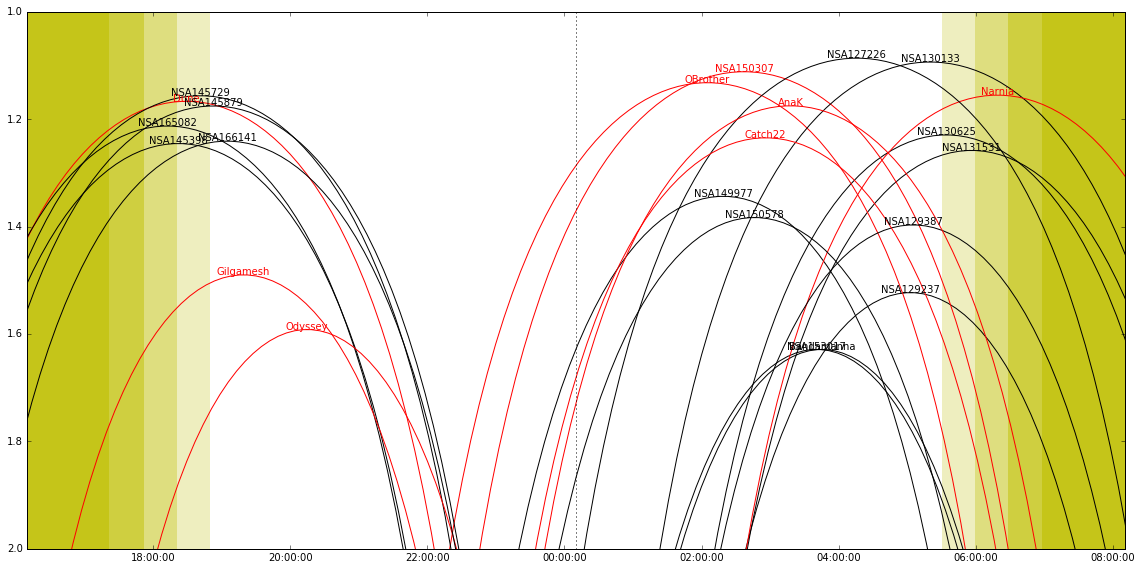

In [17]:
up_times = {}

with open('aat_targets_jul2016/aattargs_iobserve.dat', 'w') as f:
    for host in hosttab[visenough]:
        already_obs = host['NSAID'] in sagaobsed_nsaids
        
        name = 'NSA'+str(host['NSAID'])
        for nm, val in hsd.items():
            if val.nsaid == host['NSAID']:
                name = nm
                if nm.startswith('NSA'):
                    name = name+'_obsed'
                break
        
        f.write(name.replace(' ','_'))
        if already_obs:
            f.write('-observed')
        f.write(' ')
        f.write(str(host['RA']) + ' ')
        f.write(str(host['Dec']) + '\n')
        
        targ = astroplan.FixedTarget(SkyCoord(host['RA'], host['Dec'], unit=u.deg), name)
        
        tpl = (name, host['NSAID'], host['RA'], host['Dec'])
        transit = aaoobs.target_meridian_transit_time(midnight, targ)
        up_times[transit.jd] = tpl
        
        
        timestoplot = transit + np.linspace(-6, 6, 100)*u.hour
        taa = aaoobs.altaz(timestoplot, targ)
        msk = taa.secz >=1
        
        color = 'r' if already_obs else 'k'
        plt.plot(timestoplot.plot_date[msk], taa.secz[msk], c=color)
        plt.text(transit.plot_date, aaoobs.altaz(transit, targ).secz, name, ha='center', color=color)

t0 = aaoobs.sun_rise_time(midnight, 'previous')
t1 = aaoobs.sun_set_time(midnight, 'previous')
t2 = aaoobs.twilight_evening_civil(midnight, 'previous')
t3 = aaoobs.twilight_evening_nautical(midnight, 'previous')
t4 = aaoobs.twilight_evening_astronomical(midnight, 'previous')
t5 = aaoobs.twilight_morning_astronomical(midnight, 'next')
t6 = aaoobs.twilight_morning_nautical(midnight, 'next')
t7 = aaoobs.twilight_morning_civil(midnight, 'next')
t8 = aaoobs.sun_rise_time(midnight, 'next')
t9 = aaoobs.sun_set_time(midnight, 'next')

plt.fill_between([t0.plot_date,t1.plot_date],1,3, lw=0, facecolor='y', alpha=.9)
plt.fill_between([t1.plot_date,t2.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t2.plot_date,t3.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t3.plot_date,t4.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t5.plot_date,t6.plot_date],1,3, lw=0, facecolor='y', alpha=.25)
plt.fill_between([t6.plot_date,t7.plot_date],1,3, lw=0, facecolor='y', alpha=.5)
plt.fill_between([t7.plot_date,t8.plot_date],1,3, lw=0, facecolor='y', alpha=.75)
plt.fill_between([t8.plot_date,t9.plot_date],1,3, lw=0, facecolor='y', alpha=.9)

plt.axvline(midnight.plot_date, ls=':', c='k')

plt.gca().xaxis_date(aaoobs.timezone)
plt.xlim(t1.plot_date-.05, t8.plot_date+.05)
plt.ylim(2,1)
plt.tight_layout()

In [18]:
#NSA urls
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID={}&submit_form=Submit'.format(nsaid))

NSA165082 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=165082&submit_form=Submit
NSA145398 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145398&submit_form=Submit
Dune http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=165536&submit_form=Submit
NSA145729 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145729&submit_form=Submit
NSA145879 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=145879&submit_form=Submit
NSA166141 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=166141&submit_form=Submit
Gilgamesh http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=166313&submit_form=Submit
Odyssey http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=147100&submit_form=Submit
OBrother http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=149781&submit_form=Submit
NSA149977 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=149977&submit_form=Submit
NSA150307 http://www.nsatlas.org/getAtlas.html?search=nsaid&nsaID=150307&submit_form=Sub

In [19]:
# DECALS URLs
for jd in sorted(up_times):
    name, nsaid, ra, dec = up_times[jd]
    print(name, 'http://legacysurvey.org/viewer?ra={}&dec={}&zoom=8'.format(ra, dec))

NSA165082 http://legacysurvey.org/viewer?ra=217.418&dec=3.23331&zoom=8
NSA145398 http://legacysurvey.org/viewer?ra=219.796&dec=5.36347&zoom=8
Dune http://legacysurvey.org/viewer?ra=221.546&dec=-0.222942&zoom=8
NSA145729 http://legacysurvey.org/viewer?ra=224.594&dec=-1.09102&zoom=8
NSA145879 http://legacysurvey.org/viewer?ra=227.456&dec=0.470085&zoom=8
NSA166141 http://legacysurvey.org/viewer?ra=230.485&dec=5.07063&zoom=8
Gilgamesh http://legacysurvey.org/viewer?ra=234.132&dec=16.6078&zoom=8
Odyssey http://legacysurvey.org/viewer?ra=248.087&dec=19.8264&zoom=8
OBrother http://legacysurvey.org/viewer?ra=335.913&dec=-3.43167&zoom=8
NSA149977 http://legacysurvey.org/viewer?ra=339.372&dec=10.5315&zoom=8
NSA150307 http://legacysurvey.org/viewer?ra=343.924&dec=-5.49535&zoom=8
NSA150578 http://legacysurvey.org/viewer?ra=346.236&dec=12.3229&zoom=8
Catch22 http://legacysurvey.org/viewer?ra=348.683&dec=4.53406&zoom=8
AnaK http://legacysurvey.org/viewer?ra=354.131&dec=0.297265&zoom=8
NSA153017 http

Notes:
* NSA165082: in DECALS DR2, only z-band, looks like a group, elliptical
* NSA145398: in DECALS DR2, z-band and a bit of g and r, elliptical, otherwise good
* NSA145729: in DECALS DR2, z-band and some r, OK but somewhat near SDSS edge?
* NSA145879: in DECALS DR2, z-band and some g and r, elliptical, otherwise good
* NSA166141: in DECALS DR2, z-band and some g and r, otherwise good
* NSA149977: in DECALS DR2, z-band and some g and r, otherwise good
* NSA150578: in DECALS DR2, only z-band, otherwise good
* NSA153017: in DECALS DR2, only z-band, otherwise good
* Bandamanna: in DECALS DR2, only z-band, otherwise good
* NSA127226: otherwise good
* NSA129237: in DECALS DR2, only z-band, otherwise good
* NSA129387: otherwise good
* NSA130133: elliptical? otherwise good
* NSA130625: S0? otherwise good
* NSA131531: near SDSS edge, otherwise good

In [440]:
sagaobsed[sagaobsed['HOST_NSAID']==150307].show_in_notebook()

idx,objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PCLASS_1,PCLASS_1_WISE,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
0,1237680064810057894,343.294258523,-5.58921577634,3,105622104310288,50,21.2786,20.0779,18.963,18.5593,18.1466,0.270392,0.0371932,0.0206606,0.0215363,0.05477,0.189258,0.139254,0.100999,0.0765843,0.0542992,20.0711,20.6936,0.962713,21.1962808426,1.66848,5.27627,19.0445,22.1515399943,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,15.196,0.027356,14.782,0.103,0.321661,-1.0,-1,0.306445,0.066518,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,38.0301638926,435.921017981,-1,0,6.89668104769e-05,0.000141353059347,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_1-bright.fits,4.0,
1,1237680064810123417,343.444169465,-5.54131590337,3,35255507615760,56,18.9342,17.7578,17.0971,16.6959,16.4372,0.0381764,0.00654818,0.00535618,0.00539426,0.013033,0.192689,0.141779,0.10283,0.0779727,0.0552836,18.2142,18.8859,1.59287,20.103459924,1.86204,4.3,17.0562,20.4016001454,15.864,0.094,15.086,0.114,14.702,0.127,13.6805,0.00660505,13.686,0.053,0.0897762,-1.0,-1,0.115424,0.022878,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,28.7899180127,330.007508884,-1,0,0.00252629972319,0.00556550653963,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_3-bright.fits,4.0,
2,1237680065346994239,343.326444569,-5.2758046794,3,35253360132112,69,20.2127,18.9821,18.306,17.8976,17.6584,0.101598,0.0129432,0.0111533,0.0113838,0.0293664,0.18861,0.138778,0.100653,0.0763222,0.0541134,19.1818,19.8479,1.34581,20.9463948466,1.47876,3.40242,18.2951,21.1400208873,16.662,0.15,15.523,9999.0,15.076,9999.0,15.1883,0.0233187,15.133,0.157,0.0735444,-1.0,-1,0.107555,0.023803,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,38.0419851507,436.056513705,-1,0,0.00350788986243,0.00289022683502,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_3-bright.fits,4.0,
3,1237680064810123422,343.302816457,-5.49094372909,3,35253360001368,83,20.0244,18.6582,17.7721,17.2416,16.9345,0.103341,0.0132388,0.0092604,0.00862031,0.0214026,0.188044,0.138361,0.100351,0.076093,0.0539509,18.9995,19.6448,1.27988,20.6224121084,1.72586,4.90918,17.9297,21.1102191001,16.267,0.116,15.282,0.121,14.861,0.13,14.0669,0.00935812,13.831,0.052,0.167784,-1.0,-1,0.156491,0.024198,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,37.1006559893,425.266946008,-1,0,-1.0,-1.0,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_2-bright.fits,4.0,
4,1237680189904519388,343.283100026,-5.30773665895,3,35221147881488,78,19.5718,18.9171,18.2944,18.0194,17.7969,0.0678622,0.0132323,0.0122917,0.0139708,0.0377175,0.187603,0.138037,0.100116,0.0759148,0.0538245,19.474,20.1938,1.83255,21.6051758386,1.77031,3.56664,18.3302,21.5658893491,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,15.2708,0.0266607,15.173,0.168,0.232963,-1.0,-1,0.244854,0.046643,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,39.8981754873,457.332174987,-1,0,0.0012627662232,0.00110375076419,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_1-bright.fits,4.0,
5,1237680064809992382,343.13867092,-5.61561546823,3,105622104179216,7,22.6003,19.9505,18.6474,18.1128,17.8022,1.13625,0.0439179,0.0207497,0.0198917,0.0542759,0.188922,0.139007,0.10082,0.0764484,0.0542029,20.1344,20.8094,1.89454,22.4062551834,1.91264,5.06024,18.9467,22.3503180692,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.7826,0.0188548,9999.0,9999.0,0.204143,-1.0,-1,0.211551,0.029907,343.924,-5.49535,39.406,2859.0,9.229,150307,0,,47.4550105436,543.947207645,-1,0,5.09129220406e-05,nan,-1,WIYN,/Spectra/Final/WIYN/zspec.Iliad_1-bright.fits,4.0,
6,1237680189904585058,343.424951295,-5.48902686711,3,69055152456,87,23.2376,19.8928,18.4575,17.9489,17.5412,1.08794,0.0205951,0.0113408,0.0111655,0.0210086,0.190969,0.140513,0.101912,0.0772768,0.0547902,19.1858,19

Note: NSA150307 was called "Iliad" when it was observed on WIYN

## Mock sets of configurations  

In [227]:
for h in hosts_to_target:
    fnbase = 'aat_targets_jul2016/test_runs/' + h.name

    finum = 1
    fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
    fnconfig = fnbase + '_test_{0}.fld'.format(finum)
    print('Writing', fnconfig, 'from master', fnmaster)

    listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
    aat.subsample_from_master_fld(fnmaster, fnconfig,
                                  {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                                  nflux=5, nguides=30,
                                  fieldname=str(finum), listorem=listorem)
    print('')

Writing aat_targets_jul2016/Narnia_test_1.fld from master aat_targets_jul2016/Narnia_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 98 skies not included):
{1: 2728, 2: 655, 3: 405, 4: 97, 5: 145, 6: 313, 7: 191, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%

Writing aat_targets_jul2016/Catch22_test_1.fld from master aat_targets_jul2016/Catch22_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 89 skies not included):
{1: 2976, 2: 752, 3: 429, 4: 64, 5: 119, 6: 525, 7: 285, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: None, 9: None}%

Writing aat_targets_jul2016/Dune_test_1.fld from master aat_targets_jul2016/Dune_master.fld
Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included):
{1: 3812, 2: 1136, 3: 407, 4: 182, 5: 125, 6: 156, 7: 81, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 100.0, 7: 100.0, 8: N

In [175]:
for h in hosts_to_target:
    fnbase = 'aat_targets_jul2016/test_runs/' + h.name

    finum = 2
    fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
    fnconfig = fnbase + '_test_{0}.fld'.format(finum)
    print('Writing', fnconfig, 'from master', fnmaster)

    listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
    aat.subsample_from_master_fld(fnmaster, fnconfig,
                                  {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                                  nflux=5, nguides=30,
                                  fieldname=str(finum), listorem=listorem)
    print('')

Writing aat_targets_jul2016/Narnia_test_2.fld from master aat_targets_jul2016/Narnia_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Narnia_test_1.lis
Total remaining in each priority (5 fluxes, 30 guides, and 98 skies not included):
{1: 2728, 2: 655, 3: 404, 4: 93, 5: 130, 6: 149, 7: 23, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 99.75308641975309, 4: 95.87628865979381, 5: 89.65517241379311, 6: 47.6038338658147, 7: 12.041884816753926, 8: None, 9: 0.0}%

Writing aat_targets_jul2016/Dune_test_2.fld from master aat_targets_jul2016/Dune_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Dune_test_1.lis
Total remaining in each priority (5 fluxes, 30 guides, and 94 skies not included):
{1: 3812, 2: 1136, 3: 406, 4: 148, 5: 24, 6: 14, 7: 7, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 99.75429975429975, 4: 81.31868131868131, 5: 19.2, 6: 8.974358974358974, 7: 8.641975308641975,

In [188]:
for h in hosts_to_target:
    fnbase = 'aat_targets_jul2016/test_runs/' + h.name

    finum = 3
    fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
    fnconfig = fnbase + '_test_{0}.fld'.format(finum)
    print('Writing', fnconfig, 'from master', fnmaster)

    listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
    aat.subsample_from_master_fld(fnmaster, fnconfig,
                                  {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                                  nflux=5, nguides=30,
                                  fieldname=str(finum), listorem=listorem)
    print('')

Writing aat_targets_jul2016/Narnia_test_3.fld from master aat_targets_jul2016/Narnia_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Narnia_test_1.lis
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Narnia_test_2.lis
Total remaining in each priority (5 fluxes, 30 guides, and 98 skies not included):
{1: 2717, 2: 638, 3: 377, 4: 43, 5: 35, 6: 17, 7: 2, 8: 0, 9: 0}
{1: 99.59677419354838, 2: 97.40458015267176, 3: 93.08641975308642, 4: 44.329896907216494, 5: 24.137931034482758, 6: 5.431309904153355, 7: 1.0471204188481675, 8: None, 9: 0.0}%

Writing aat_targets_jul2016/Dune_test_3.fld from master aat_targets_jul2016/Dune_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Dune_test_1.lis
Kept the following fibers in due to zltabkeepfunc: []
Found 268 objects to remove in aat_targets_jul2016/Dune_test_2.lis

Basically there after 2 observations of  Narnia and OBrother.  AnaK and Dune 1 or maybe 2, Gilg/Ody 1.

Guess: Catch 22 requires 2 or 3

NSA 145729 and maybe 165082? 

### Catch22 added later 

In [231]:
h = hsd['Catch22']
fnbase = 'aat_targets_jul2016/test_runs/' + h.name

finum = 2
fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
fnconfig = fnbase + '_test_{0}.fld'.format(finum)
print('Writing', fnconfig, 'from master', fnmaster)

listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)

Writing aat_targets_jul2016/Catch22_test_2.fld from master aat_targets_jul2016/Catch22_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Catch22_test_1.lis
Total remaining in each priority (5 fluxes, 30 guides, and 89 skies not included):
{1: 2976, 2: 752, 3: 429, 4: 64, 5: 119, 6: 411, 7: 46, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 100.0, 4: 100.0, 5: 100.0, 6: 78.28571428571429, 7: 16.140350877192983, 8: None, 9: None}%


In [232]:
h = hsd['Catch22']
fnbase = 'aat_targets_jul2016/test_runs/' + h.name

finum = 3
fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
fnconfig = fnbase + '_test_{0}.fld'.format(finum)
print('Writing', fnconfig, 'from master', fnmaster)

listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)

Writing aat_targets_jul2016/Catch22_test_3.fld from master aat_targets_jul2016/Catch22_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Catch22_test_1.lis
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Catch22_test_2.lis
Total remaining in each priority (5 fluxes, 30 guides, and 89 skies not included):
{1: 2976, 2: 752, 3: 426, 4: 63, 5: 88, 6: 137, 7: 2, 8: 0, 9: 0}
{1: 100.0, 2: 100.0, 3: 99.3006993006993, 4: 98.4375, 5: 73.94957983193277, 6: 26.095238095238095, 7: 0.7017543859649122, 8: None, 9: None}%


In [235]:
h = hsd['Catch22']
fnbase = 'aat_targets_jul2016/test_runs/' + h.name

finum = 4
fnmaster = fnbase.replace('test_runs/', '') + '_master.fld'
fnconfig = fnbase + '_test_{0}.fld'.format(finum)
print('Writing', fnconfig, 'from master', fnmaster)

listorem = [fnbase + '_test_' + str(i) + '.lis' for i in range(1, finum)]
aat.subsample_from_master_fld(fnmaster, fnconfig,
                              {1:30, 2:30, 3:30, 4:np.inf, 5:np.inf, 6:np.inf, 7:np.inf, 8:np.inf, 9:np.inf}, #8 reserved for flux
                              nflux=5, nguides=30,
                              fieldname=str(finum), listorem=listorem)

Writing aat_targets_jul2016/Catch22_test_4.fld from master aat_targets_jul2016/Catch22_master.fld
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Catch22_test_1.lis
Kept the following fibers in due to zltabkeepfunc: []
Found 353 objects to remove in aat_targets_jul2016/Catch22_test_2.lis
Kept the following fibers in due to zltabkeepfunc: []
Found 317 objects to remove in aat_targets_jul2016/Catch22_test_3.lis
Total remaining in each priority (5 fluxes, 30 guides, and 89 skies not included):
{1: 2957, 2: 724, 3: 397, 4: 13, 5: 18, 6: 18, 7: 0, 8: 0, 9: 0}
{1: 99.36155913978494, 2: 96.27659574468085, 3: 92.54079254079254, 4: 20.3125, 5: 15.126050420168067, 6: 3.4285714285714284, 7: 0.0, 8: None, 9: None}%


## Log from last run 

In [346]:
logtab2015 = make_logtab('aat_targets_jul2016/alljun_2015_aaomega_headers')

In [544]:
logtab2015[(logtab2015['ccd']==1)].show_in_notebook(display_length=20)

idx,num,ccd,UTDATE,UTSTART,OBJECT,TOTALEXP,RUNCMD,GRATID,SOURCE,MEANRA,MEANDEC,CFG_FILE
0,10001,1,2015:06:19,08:56:19,Fibre Flat Field - Quartz_75_A,4.,FLAT,580V,plate 0,221.546377452,-0.222954220588,Dune_1p0.sds
1,10002,1,2015:06:19,08:58:47,Fibre Flat Field - Quartz_75_A,25.,FLAT,580V,plate 0,221.546356619,-0.222936925056,Dune_1p0.sds
2,10003,1,2015:06:19,09:01:45,ARC - FeAr_1 FeAr_2 CuAr_1 CuAr_2 CuHe_1 CuNe_1,45.,ARC,580V,plate 0,221.546364632,-0.222939560562,Dune_1p0.sds
3,10004,1,2015:06:19,10:54:11,Fibre Flat Field - Quartz_75_A,4.,FLAT,580V,plate 1,221.546400952,-0.222954199967,Dune_1p1.sds
4,10005,1,2015:06:19,10:56:42,Fibre Flat Field - Quartz_75_A,25.,FLAT,580V,plate 1,221.546391869,-0.22291846743,Dune_1p1.sds
5,10006,1,2015:06:19,10:59:28,ARC - FeAr_1 FeAr_2 CuAr_1 CuAr_2 CuHe_1 CuNe_1,45.,ARC,580V,plate 1,221.546367689,-0.222955327287,Dune_1p1.sds
6,10007,1,2015:06:19,13:31:31,Fibre Flat Field - Quartz_75_A,4.,FLAT,580V,plate 0,221.545561468,-0.220320318818,Odyssey_1p0.sds
7,10008,1,2015:06:19,13:33:53,Fibre Flat Field - Quartz_75_A,25.,FLAT,580V,plate 0,221.545556258,-0.220305052591,Odyssey_1p0.sds
8,10009,1,2015:06:19,13:36:40,ARC - FeAr_1 FeAr_2 CuAr_1 CuAr_2 CuHe_1 CuNe_1,45.,ARC,580V,plate 0,221.545525634,-0.220313397766,Odyssey_1p0.sds
9,10010,1,2015:06:19,13:40:54,Fibre Flat Field - Quartz_75_A,4.,FLAT,580V,plate 0,248.087274345,19.8264618711,Odyssey_1p0.sds
